## <center>Assignment</center>

1. Devise Word2Vec model by subclassing keras.Model
   
    - you can copy the `embedding_lookup`, `nce_loss` code above


1. Train your word2vec model and plot your learning curve
2. Visualize your embedding matrix by t-SNE
3. Show top-5 nearest neighbors of two words.(pick by yourself)
4. Submit your **ipynb** to eeclass with the format Lab10_{student_id}.ipynb.

- Deadline: 2023-11-02 (Thur) 23:59

### Import and Read data

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning and info message
import tensorflow as tf
import numpy as np
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import zipfile

# Read the data into a list of strings.
def read_data(file_path):
    """ Read data into a list of tokens """
    with zipfile.ZipFile(file_path) as f:
        # tf.compat.as_str() converts the input into string
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data("data/text8.zip")
print('Data size', len(vocabulary))
vocabulary[:5]

Data size 17005207


['anarchism', 'originated', 'as', 'a', 'term']

### Build the dictionar

In [4]:
import collections
# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
    """ Create two dictionaries and count of occuring words
        - word_to_id: map of words to their codes
        - id_to_word: maps codes to words (inverse word_to_id)
        - count: map of words to count of occurrences
    """
    # map unknown words to -1
    count = [['UNK', -1]]
    # count of occurences for words in vocabulary
    count.extend(collections.Counter(words).most_common(n_words - 1)) 
    word_to_id = dict() # (word, id)
    # record word id
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys())) # (id, word)
    return word_to_id, id_to_word, count

def convert_words_to_id(words, dictionary, count):
    """ Replace each word in the dataset with its index in the dictionary """
    data_w2id = []
    unk_count = 0
    for word in words:
        # return 0 if word is not in dictionary
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data_w2id.append(index)
    count[0][1] = unk_count
    return data_w2id, count

In [5]:
"""Filling 4 global variables:
# data_w2id - list of codes (integers from 0 to vocabulary_size-1).
              This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# word_to_id - map of words(strings) to their codes(integers)
# id_to_word - maps codes(integers) to words(strings)
"""

vocabulary_size = 50000
word_to_id, id_to_word, count = build_dataset(vocabulary, vocabulary_size)
data_w2id, count = convert_words_to_id(vocabulary, word_to_id, count)
del vocabulary  # reduce memory.

In [6]:
# utility function
def generate_sample(center_words, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for idx, center in enumerate(center_words):
        context = random.randint(1, context_window_size)
        # get a random target before the center word
        for target in center_words[max(0, idx - context) : idx]:
            yield center, target
        # get a random target after the center word
        for target in center_words[idx + 1 : idx + context + 1]:
            yield center, target

def batch_generator(data, skip_window, batch_size):
    """ Group a numeric stream into batches and yield them as Numpy arrays. """
    single_gen = generate_sample(data, skip_window)
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for idx in range(batch_size):
            center_batch[idx], target_batch[idx] = next(single_gen)
        yield center_batch, target_batch

### Model SubClassing

In [7]:
## some training settings
training_steps = 40000
skip_step = 2000

## some hyperparameters
batch_size = 512
embed_size = 512
num_sampled = 256
learning_rate = 1.0

In [8]:
# from tensorflow.keras.layers import Layer
from tensorflow.python.keras.layers import Layer

# embedding matrix - hidden layer
class embedding_lookup(Layer):
    def __init__(self, vocabulary_size, embed_size):
        super(embedding_lookup, self).__init__()
        embedding_init = tf.keras.initializers.GlorotUniform()
        self.embedding_matrix = self.add_weight(name="embedding_matrix",
                                                trainable=True,
                                                shape=[vocabulary_size, embed_size],
                                                initializer=embedding_init)

    def call(self, inputs):
        center_words = inputs
        embedding = tf.nn.embedding_lookup(self.embedding_matrix,
                                           center_words, 
                                           name='embedding')
        return embedding

# context matrix - prediction layer
class nce_loss(Layer):
    def __init__(self, vocabulary_size, embed_size):
        super(nce_loss, self).__init__()
        nce_w_init = tf.keras.initializers.TruncatedNormal(stddev=1.0/(embed_size ** 0.5))
        self.nce_weight = self.add_weight(name='nce_weight',
                                          trainable=True,
                                          shape=[vocabulary_size, embed_size],
                                          initializer=nce_w_init)
        self.nce_bias = self.add_weight(name='nce_bias',
                                        trainable=True,
                                        shape=[vocabulary_size],
                                        initializer=tf.keras.initializers.Zeros)
        

    def call(self, inputs, num_sampled, vocabulary_size):
        embedding, target_words = inputs[0], inputs[1]
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                             biases=self.nce_bias, 
                                             labels=target_words, 
                                             inputs=embedding, 
                                             num_sampled=num_sampled, 
                                             num_classes=vocabulary_size),
                                             name='loss')
        return loss

In [9]:
# from tensorflow.keras import Model
from tensorflow.python.keras import Model

class Word2Vec(Model):
    def __init__(self, vocabulary_size, embed_size):
        '''To-Do: Define model variables'''
        super(Word2Vec, self).__init__()
        self.embedding_lookup = embedding_lookup(vocabulary_size, embed_size)
        self.nce_loss = nce_loss(vocabulary_size, embed_size)

    def call(self, center_words, target_words, num_sampled, vocabulary_size):
        '''To-Do: Define data flow and return loss'''
        embedding = self.embedding_lookup(center_words)
        loss = self.nce_loss((embedding, target_words), num_sampled, vocabulary_size)
        
        return loss

In [10]:
from tensorflow.python.keras import Input

center_words = Input(shape=(), name='center_words', dtype='int32')
target_words = Input(shape=(1), name='target_words', dtype='int32')

word2vec = Word2Vec(vocabulary_size, embed_size)

loss = word2vec(center_words, target_words, num_sampled, vocabulary_size)

word2vec.summary()

Model: "word2_vec"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_lookup (embedding_ multiple                  25600000  
_________________________________________________________________
nce_loss (nce_loss)          multiple                  25650000  
Total params: 51,250,000
Trainable params: 51,250,000
Non-trainable params: 0
_________________________________________________________________


In [11]:
## geneartor for `tf.data.Dataset`
def gen():
    """ Return a python generator that generates batches. """
    yield from batch_generator(data_w2id, 2, batch_size)

    

dataset = tf.data.Dataset.from_generator(gen, 
                                         (tf.int32, tf.int32),
                                         (tf.TensorShape([batch_size]), tf.TensorShape([batch_size, 1])))\
                         .repeat()

In [12]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1,nesterov=True)

In [13]:
@tf.function
def train_step(center_words, target_words):
    with tf.GradientTape() as tape:
        loss = word2vec(center_words, target_words, num_sampled, vocabulary_size)
    gradients = tape.gradient(loss, word2vec.trainable_variables)
    optimizer.apply_gradients(zip(gradients, word2vec.trainable_variables))

    train_loss(loss)

In [14]:
x = []
y = []
for step, (center_words, target_words) in enumerate(dataset):
    if step == training_steps:
        break
    train_step(center_words, target_words)

    if ((step+1) % skip_step) == 0:
        template = 'Step {:0}, Loss: {:.2f}'
        x.append(step+1)
        y.append(train_loss.result())
        print(template.format(step+1, train_loss.result()))
        train_loss.reset_states()

Step 2000, Loss: 174.54
Step 4000, Loss: 31.48
Step 6000, Loss: 15.49
Step 8000, Loss: 10.68
Step 10000, Loss: 9.67
Step 12000, Loss: 8.76
Step 14000, Loss: 8.17
Step 16000, Loss: 7.44
Step 18000, Loss: 7.18
Step 20000, Loss: 6.96
Step 22000, Loss: 6.92
Step 24000, Loss: 6.74
Step 26000, Loss: 6.59
Step 28000, Loss: 6.41
Step 30000, Loss: 6.42
Step 32000, Loss: 6.39
Step 34000, Loss: 6.28
Step 36000, Loss: 6.26
Step 38000, Loss: 6.15
Step 40000, Loss: 6.14


### Learning Curve

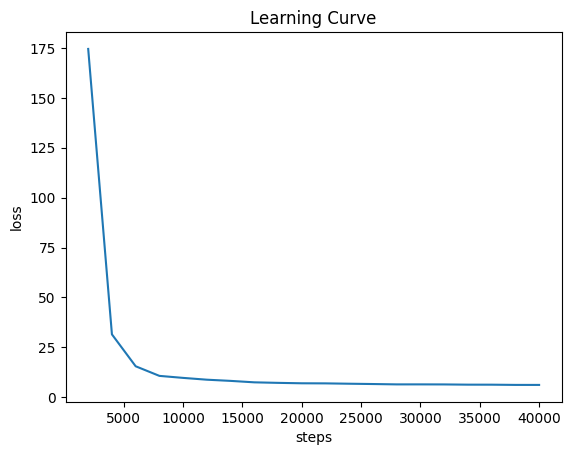

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.plot(x, y)
plt.show()

### Visualizing the learned embeddings

In [16]:
# get embedding matrix from model weights. > word2vec.weights[0]
embedding_matrix = word2vec.weights[0]

In [17]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18), dpi=150)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')

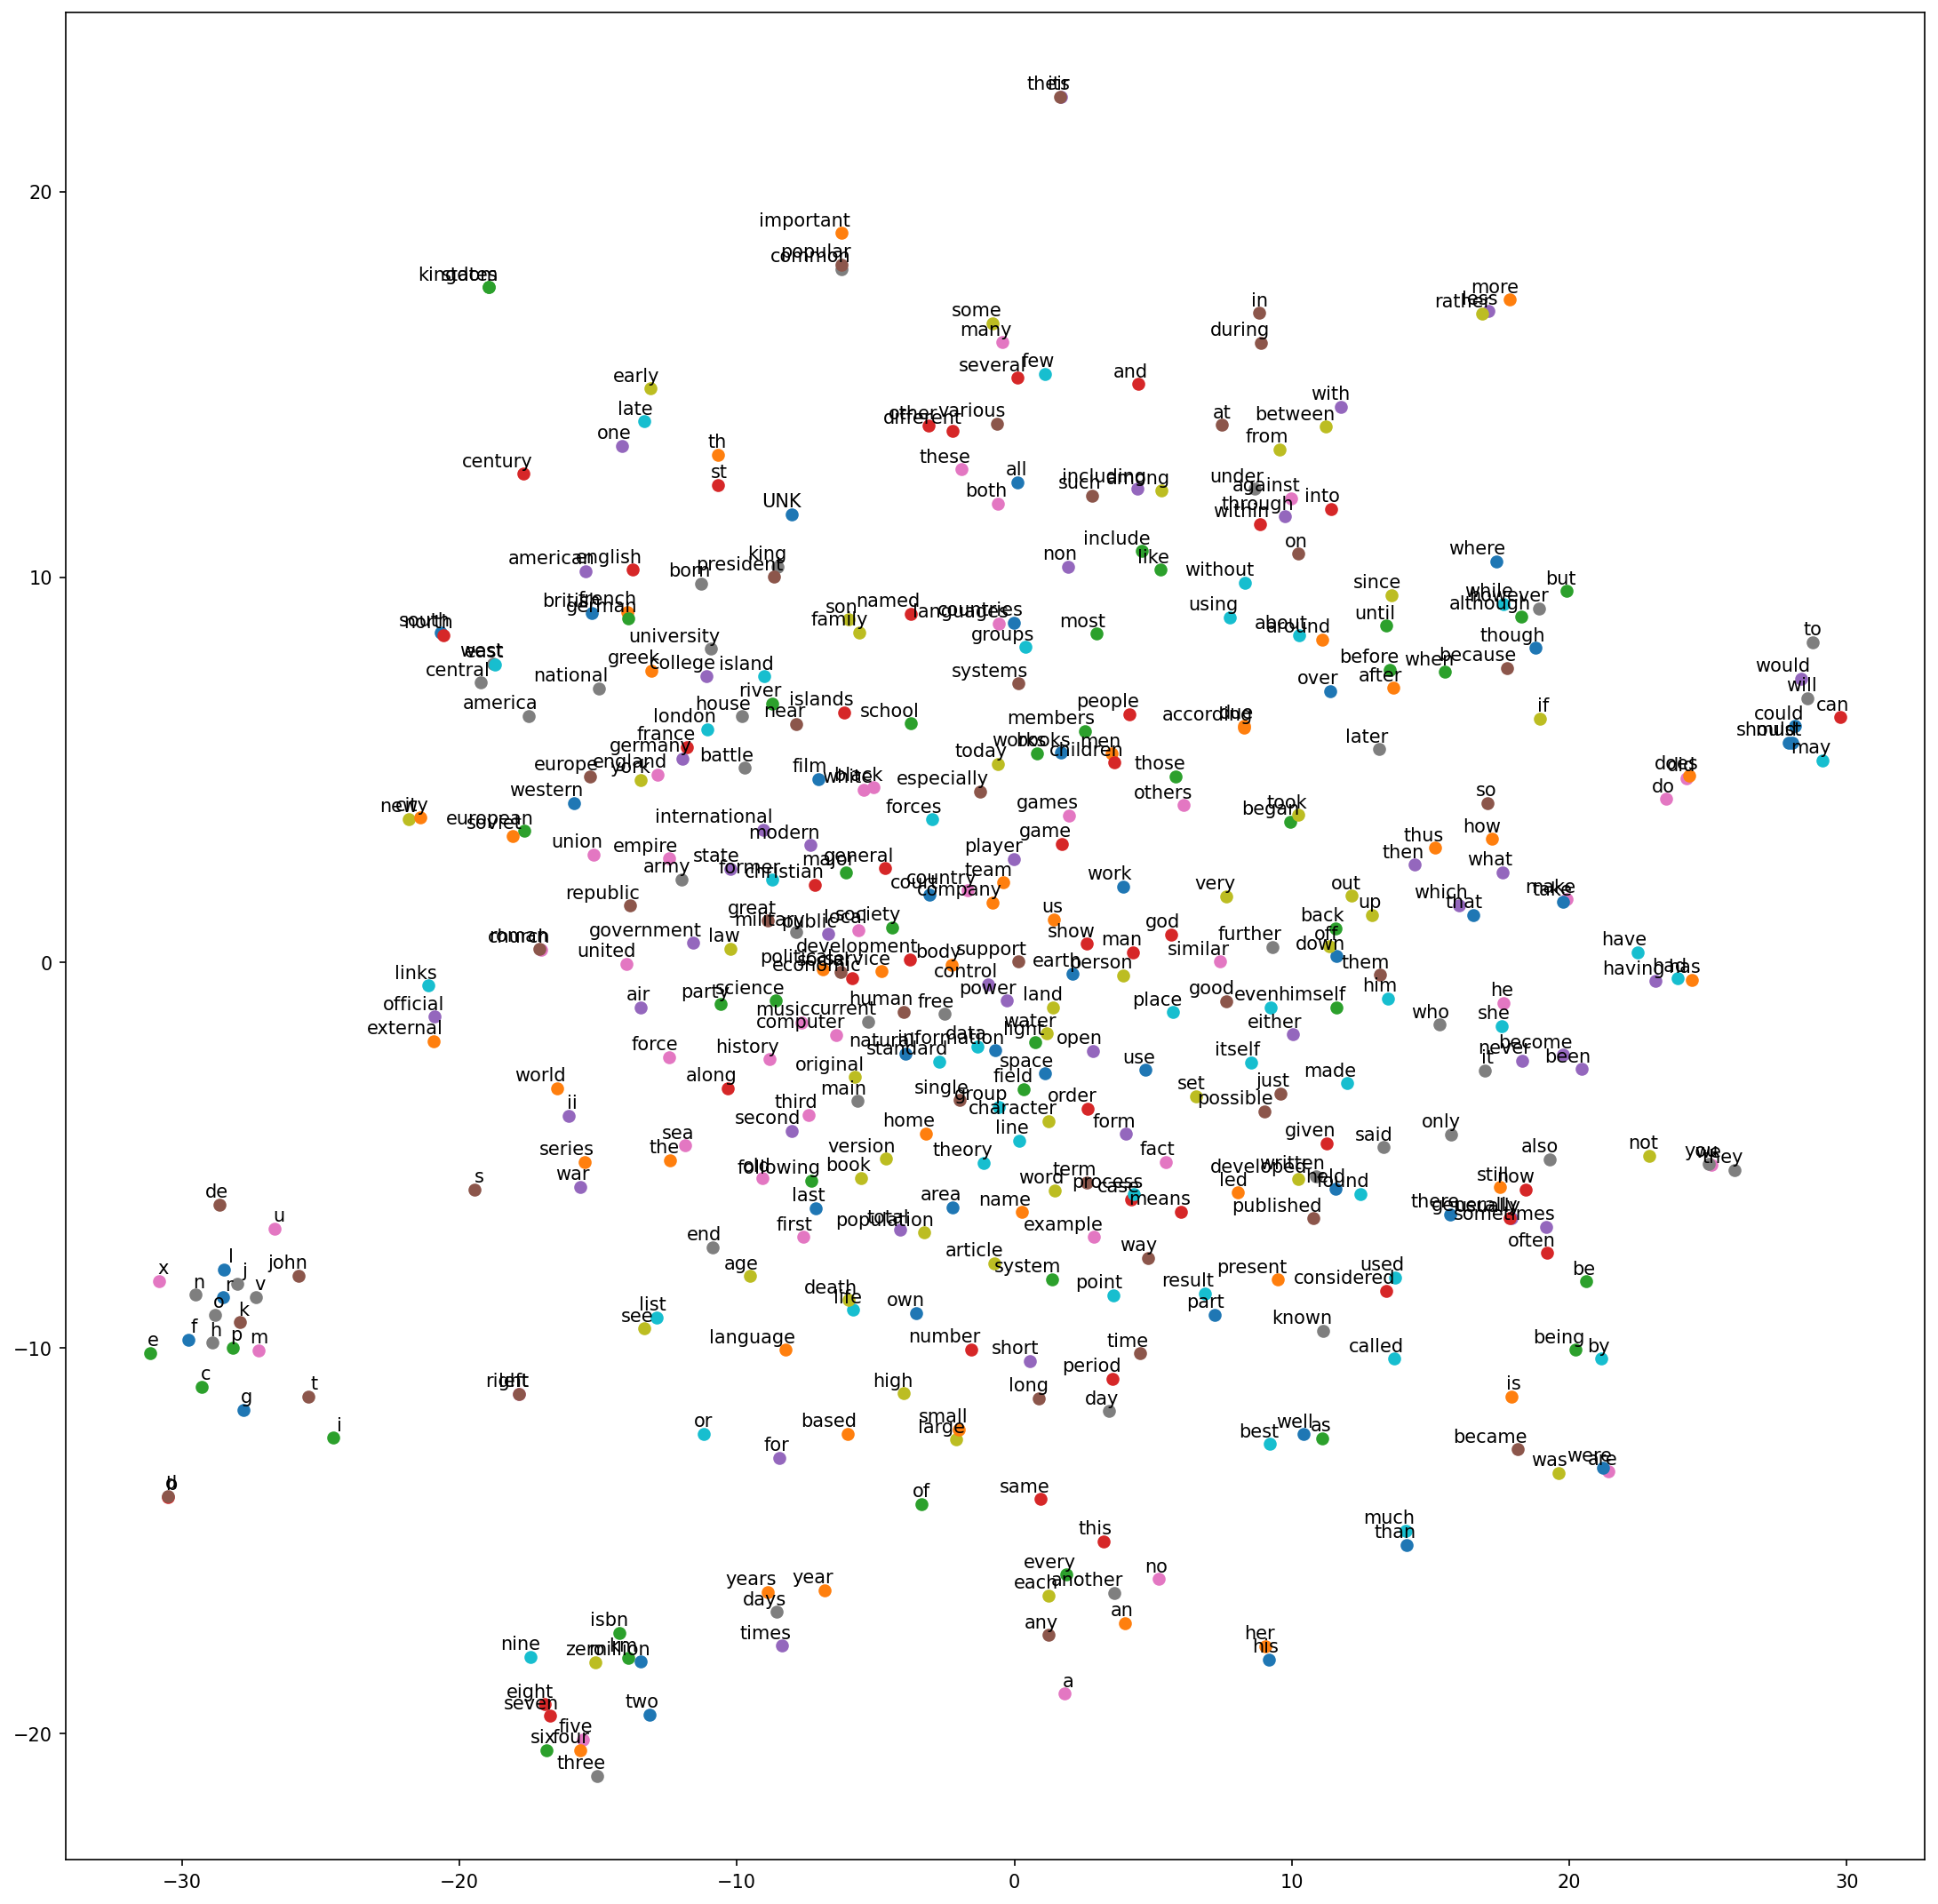

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact', learning_rate='auto')
plot_only = 400
final_embeddings = embedding_matrix
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

### Top-5 Nearest

In [19]:
import numpy.linalg as LA

In [20]:
def top_k_nearest(word, k):
    vec = embedding_matrix[word_to_id[word]]
    
    # calaulate cosine similarity  of `vec` and all other vocabularies
    dot = np.dot(embedding_matrix.numpy(), vec)
    embedding_norm = LA.norm(embedding_matrix.numpy(), axis=-1)
    vec_norm = LA.norm(vec)
    norm_product = embedding_norm * vec_norm
    cos_sim = dot / norm_product
    
    # print out top k nearest words
    indices = np.argsort(cos_sim)[::-1][:k]
    print('---top {} nearest words of {}---'.format(k, word))
    for idx in indices:
        print(id_to_word[idx])
    print('\n')

In [21]:
top_k_nearest('dog', 5)
top_k_nearest('computer', 5)

---top 5 nearest words of dog---
dog
bull
miller
corporation
giant


---top 5 nearest words of computer---
computer
digital
software
business
video


